## Анализ релевантности

Отсеивать ненужные видео будем следующим образом: поскольку мы уже имеем в распоряжении предобученный детектор лиц, то заставим его поработать на наших данных с камер, где он будет вычленять лица на записях и считать их количество. Если количество людей на фрагменте будет меньше определенного порога, то эту запись будем считать нерелевантной и исключим из датасета.

Используем FastMTCNN, в прошлый раз мы смогли добиться на ней быстродействия до 120 кад/с. Проверим качество ее работы на наших данных.

In [1]:
!pip install facenet-pytorch

In [2]:
!pip show imutils

In [3]:
!unzip -a Archive.zip

Archive:  Archive.zip
  inflating: vid113_trimmed_20s.mp4  [binary]
  inflating: vid112_trimmed_20s.mp4  [binary]
  inflating: vid111_trimmed_20s.mp4  [binary]
  inflating: vid110_trimmed_20s.mp4  [binary]
  inflating: vid109_trimmed_20s.mp4  [binary]
  inflating: vid107_trimmed_20s.mp4  [binary]
  inflating: vid106_trimmed_20s.mp4  [binary]
  inflating: vid105_trimmed_20s.mp4  [binary]
  inflating: vid104_trimmed_20s.mp4  [binary]
  inflating: vid103_trimmed_20s.mp4  [binary]
  inflating: vid102_trimmed_20s.mp4  [binary]
  inflating: vid101_trimmed_20s.mp4  [binary]
  inflating: vid100_trimmed_20s.mp4  [binary]
  inflating: vid99_trimmed_20s.mp4   [binary]
  inflating: vid98_trimmed_20s.mp4   [binary]
  inflating: vid97_trimmed_20s.mp4   [binary]
  inflating: vid96_trimmed_20s.mp4   [binary]
  inflating: __MACOSX/._vid96_trimmed_20s.mp4  [binary]
  inflating: vid95_trimmed_20s.mp4   [binary]
  inflating: __MACOSX/._vid95_trimmed_20s.mp4  [binary]
  inflating: vid94_trimmed_20s.mp4   [

In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw
import torch
from imutils.video import FileVideoStream
import cv2
import time
import glob
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

filenames = [f for f in listdir('MIEM_full_dataset') if isfile(join('MIEM_full_dataset', f))]

In [6]:
filenames

In [8]:
class FastMTCNN(object):

    def __init__(self, stride, resize=1, *args, **kwargs):

        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)

    def __call__(self, frames):

        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]

        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        frames_pr = []
        batch_num_faces = 0
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            batch_num_faces = max(batch_num_faces, len(boxes[box_ind]))
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
                frames_pr.append(frame)

        return faces, frames_pr, batch_num_faces

In [9]:
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device
)

In [10]:
cap = cv2.VideoCapture(filenames[0])
print("Fps: ", cap.get(cv2.CAP_PROP_FPS))
qqq = cap.read()
print("Fps: ", cap.get(cv2.CAP_PROP_FPS))

Fps:  25.0
Fps:  25.0


In [21]:
def run_detection_fmtcnn(fast_mtcnn, filenames):
    frames = []
    faces_pr = []
    frames_pr = []
    to_delete = []
    threshold = 2
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))
        max_faces = 0
        frames_c = []
        k = 0
        print(v_cap, v_len)

        for j in range(v_len):

            frame = v_cap.read()
            if frame is not None:
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              frames.append(frame)

              if len(frames) >= batch_size or j == v_len - 1:

                  faces, frames_c, faces_count = fast_mtcnn(frames)

                  if faces_count > max_faces:
                    max_faces = faces_count

                  faces_pr.extend(faces)
                  frames_pr.extend(frames_c)
                  frames_processed += len(frames)
                  faces_detected += len(faces)
                  frames = []

                  print(f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                        f'faces detected: {faces_detected}\r',
                        end = ''
                  )
        if max_faces < threshold:
          to_delete.append(filename)

        v_cap.stop()
    return frames_pr, faces_pr, to_delete

In [ ]:
frames, faces, to_del = run_detection_fmtcnn(fast_mtcnn, filenames)

  0%|          | 0/109 [00:00<?, ?it/s]

<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a41810> 500
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a43cd0> 502
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a43e20> 502
<imutils.video.filevideostream.FileVideoStream object at 0x791811227bb0> 502
<imutils.video.filevideostream.FileVideoStream object at 0x79180620b910> 502
<imutils.video.filevideostream.FileVideoStream object at 0x79190231cf10> 500
<imutils.video.filevideostream.FileVideoStream object at 0x79180620b910> 502
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a41ed0> 502
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a41000> 500
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a43100> 500
<imutils.video.filevideostream.FileVideoStream object at 0x79180620b9d0> 500
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a415d0> 500
<imutils.video.filevideostream.FileVideoStream object at 0x7917c9a42e30> 500

In [11]:
print(len(faces), len(frames))

0 0


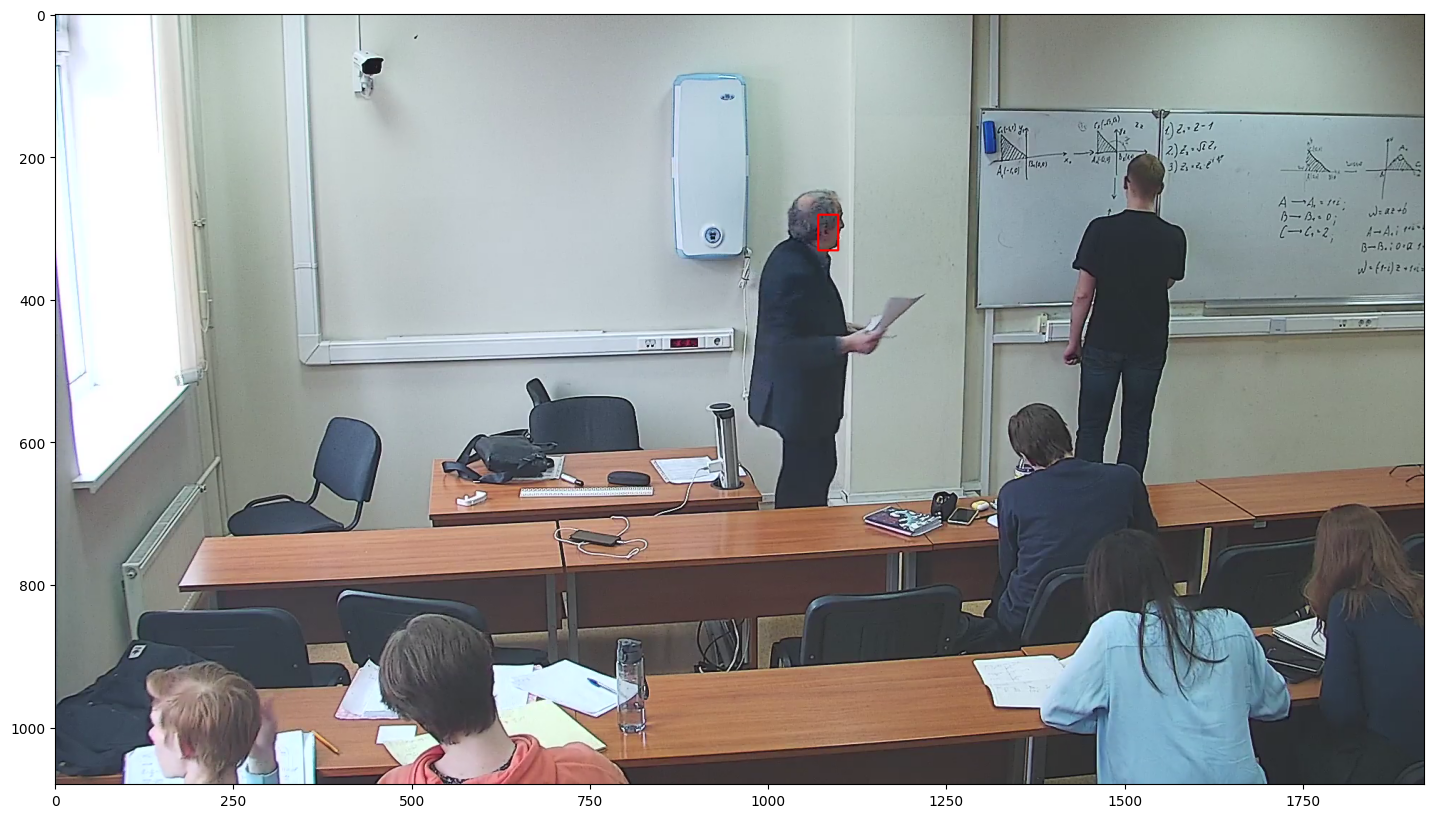

In [44]:
plt.figure(figsize=(20,10))
plt.imshow(frames[415])

Очевидно, что людей, присутствующих в кадре, но повертнутых к камере спиной, сеть не детектирует, что, на самом деле, является преимуществом, поскольку исходная задача состоит не только в детекции человека, но и опознание его личности, что почти невозможно сделать без запечатления лица. В таком случае будем это использовать в дальнейшем.

Для того, чтобы отсеивать нерелевантные видео установим порог (threshold) по количеству лиц. Для наибольшей наглядности и удобного инференса нужно хотя бы 2 зафиксированного лица в одном фрагменте. Чтобы уложиться в реальные рамки времени, все видео из исходного датасета были обрезаны посередине в 20-и секундные клипы.

Прогоним отобранные фрагменты через модель детекции и посчитаем лица:

In [ ]:
frames, faces, to_del = run_detection_fmtcnn(fast_mtcnn, filenames)

In [ ]:
print(to_del)